In [11]:
import pandas as pd
import catboost
import numpy as np



print('Pandas v.', pd.__version__)
print('Catboost v.', catboost.__version__)

Pandas v. 1.2.3
Catboost v. 0.24.4


In [12]:
!ls -la

итого 1488
drwxrwxr-x 3 nar nar   4096 фев 26 16:59  .
drwxrwxr-x 7 nar nar   4096 фев 26 16:52  ..
-rw-rw-rw- 1 nar nar 393200 фев 21 17:43  agents2019.csv
-rw-rw-rw- 1 nar nar 630324 фев 21 17:43  agents2020.csv
-rw-rw-rw- 1 nar nar 456439 фев 21 17:43  agents2021.csv
drwxrwxr-x 2 nar nar   4096 фев 26 16:55  .ipynb_checkpoints
-rw-rw-r-- 1 nar nar     79 фев 26 16:53 '.~lock.Описание файлов_контрагенты.docx#'
-rw-rw-r-- 1 nar nar    870 фев 26 16:59  Untitled.ipynb
-rw-rw-rw- 1 nar nar  19085 фев 21 17:00 'Описание файлов_контрагенты.docx'


In [75]:
df19 = pd.read_csv('agents2019.csv')
df20 = pd.read_csv('agents2020.csv')
df21 = pd.read_csv('agents2021.csv')

for i in [df19,  df21]:
    i.drop(columns=["Unnamed: 0"], inplace=True) 
    
for i in [df19, df20, df21]:
    print(i.shape, '\n')

(531, 54) 

(531, 131) 

(325, 135) 



In [367]:
## INTERSEC COLUMNS

A = set(df19.columns)
B = set(df20.columns)
C = set(df21.columns)

# Z - искомое множество одинаковых колонок в df

X = A.intersection(B)

Z = X.intersection(C)
del X

#print('COUNT columns',len(Z),'\n', 'Repeat cols \n', list(Z))

In [368]:
#!pip install matplotlib_venn

In [49]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles
from matplotlib_venn import venn2, venn2_circles

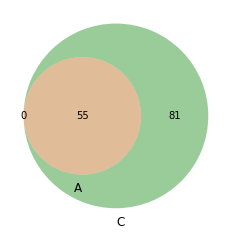

In [61]:
venn2([set(A), set(C)],  set_labels = ('A', 'C'))
plt.show()

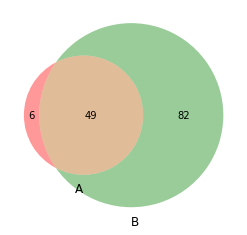

In [58]:
venn2([set(A), set(B)],  set_labels = ('A', 'B'))
plt.show()

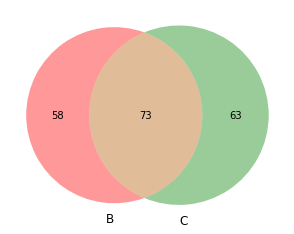

In [59]:
venn2([set(B), set(C)], set_labels = ('B', 'C'))
plt.show()

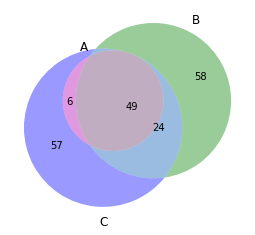

In [60]:
venn3([set(A), set(B), set(C)],  set_labels = ('A', 'B', 'C'))
plt.show()

In [77]:
cols = [] # для колонок из всех df в их первоначальном порядке 
for i in df19.columns:
    if i in Z:
        cols.append(i)

print('Vsego ', len(cols), 'cols')
print(cols)

Vsego  49 cols
['Наименование ДП', '2016, Нематериальные активы, RUB', '2017, Нематериальные активы, RUB', '2018, Нематериальные активы, RUB', '2016, Основные средства , RUB', '2017, Основные средства , RUB', '2018, Основные средства , RUB', '2016, Внеоборотные активы, RUB', '2017, Внеоборотные активы, RUB', '2018, Внеоборотные активы, RUB', '2016, Дебиторская задолженность, RUB', '2017, Дебиторская задолженность, RUB', '2018, Дебиторская задолженность, RUB', '2016, Оборотные активы, RUB', '2017, Оборотные активы, RUB', '2018, Оборотные активы, RUB', '2016, Уставный капитал , RUB', '2017, Уставный капитал , RUB', '2018, Уставный капитал , RUB', '2016, Капитал и резервы, RUB', '2017, Капитал и резервы, RUB', '2018, Капитал и резервы, RUB', '2016, Заёмные средства (долгосрочные), RUB', '2017, Заёмные средства (долгосрочные), RUB', '2018, Заёмные средства (долгосрочные), RUB', '2016, Долгосрочные обязательства, RUB', '2017, Долгосрочные обязательства, RUB', '2018, Долгосрочные обязательст

In [102]:
#Избавление от отриц знач
zamena ="Общая сумма ПДЗ свыше 5-ти дней за 2019 год, руб."
df19.loc[(df19[zamena]  < 0), zamena] = 2978865

In [113]:
cols_without_years =[]
for i in cols:
    if i[:1] == '2':  # если признак содержит год
        if i[6:] not in cols_without_years: #запишем без года
            cols_without_years.append(i[6:])
        
cols_without_years

['Нематериальные активы, RUB',
 'Основные средства , RUB',
 'Внеоборотные активы, RUB',
 'Дебиторская задолженность, RUB',
 'Оборотные активы, RUB',
 'Уставный капитал , RUB',
 'Капитал и резервы, RUB',
 'Заёмные средства (долгосрочные), RUB',
 'Долгосрочные обязательства, RUB',
 'Заёмные средства (краткосрочные), RUB',
 'Кредиторская задолженность, RUB',
 'Краткосрочные обязательства, RUB',
 'Выручка, RUB',
 'Себестоимость продаж, RUB',
 'Прибыль (убыток) до налогообложения , RUB',
 'Прибыль (убыток) от продажи, RUB']

# Добавление новых признаков отражающих ТРЕНД конкретного признака за 3 года

### Отслеживане тренда за год и наличие переходных состояний не дало результата

In [153]:
for i in cols_without_years:
    
    df19['Trend ' + i] =  (df19['2018' + ', ' + i].astype(int) - df19['2016' + ', ' + i].astype(int))  


# df19['Trend' +'2017 ' + i] =  (df19['2017' + ', ' + i].astype(int) - df19['2016' + ', ' + i].astype(int)) / df19['2016' + ', ' + i].astype(int)
# нужна функция средняя доля прироста\падения

In [158]:
cols2pred=[]
for i in cols_without_years:
    k = 'Trend ' + i
    if k not in cols2pred:
        cols2pred.append(k)
    
    k = '2018' + ', ' + i
    if k not in cols2pred:
        cols2pred.append(k)
        
cols2pred

['Trend Нематериальные активы, RUB',
 '2018, Нематериальные активы, RUB',
 'Trend Основные средства , RUB',
 '2018, Основные средства , RUB',
 'Trend Внеоборотные активы, RUB',
 '2018, Внеоборотные активы, RUB',
 'Trend Дебиторская задолженность, RUB',
 '2018, Дебиторская задолженность, RUB',
 'Trend Оборотные активы, RUB',
 '2018, Оборотные активы, RUB',
 'Trend Уставный капитал , RUB',
 '2018, Уставный капитал , RUB',
 'Trend Капитал и резервы, RUB',
 '2018, Капитал и резервы, RUB',
 'Trend Заёмные средства (долгосрочные), RUB',
 '2018, Заёмные средства (долгосрочные), RUB',
 'Trend Долгосрочные обязательства, RUB',
 '2018, Долгосрочные обязательства, RUB',
 'Trend Заёмные средства (краткосрочные), RUB',
 '2018, Заёмные средства (краткосрочные), RUB',
 'Trend Кредиторская задолженность, RUB',
 '2018, Кредиторская задолженность, RUB',
 'Trend Краткосрочные обязательства, RUB',
 '2018, Краткосрочные обязательства, RUB',
 'Trend Выручка, RUB',
 '2018, Выручка, RUB',
 'Trend Себестоимост

In [159]:
df19[cols2pred]

Trend Нематериальные активы, RUB  2018, Нематериальные активы, RUB  \
0                             6155414                      9.050955e+06   
1                               34394                      3.439490e+04   
2                             6226752                      8.694904e+06   
3                                   0                      0.000000e+00   
4                             -101274                      4.490446e+05   
..                                ...                               ...   
526                                 0                      0.000000e+00   
527                            -30573                      1.847134e+04   
528                                 0                      0.000000e+00   
529                                 0                      0.000000e+00   
530                                 0                      0.000000e+00   

     Trend Основные средства , RUB  2018, Основные средства , RUB  \
0                        255515287                   2.145239e+09   
1                          7831847                   1.526427e+08   
2                        -41067516                   9.287389e+08   
3                       5390788535                   1.426492e+10   
4                       3758086625                   3.008970e+10   
..                             ...                            ...   
526                         840764                   8.407643e+05   
527                      -32085350                   1.312414e+08   
528                              0                   0.000000e+00   
529                       19545860                   3.114713e+07   
530                              0                   0.000000e+00   

     Trend Внеоборотные активы, RUB  2018, Внеоборотные активы, RUB  \
0                         511392357                    2.440078e+09   
1                           8214013                    1.538924e+08   
2                          45407643                    1.018682e+09   
3                        7222782165                    1.820102e+10   
4                      -11249980255                    1.001542e+11   
..                              ...                             ...   
526                          840764                    8.407643e+05   
527                       -34292356                    1.452439e+08   
528                               0                    0.000000e+00   
529                       461610191                    4.922949e+08   
530                               0                    0.000000e+00   

     Trend Дебиторская задолженность, RUB  \
0                              -108304459   
1                               100500000   
2                               -53417834   
3                              2314559872   
4                              6704884713   
..                                    ...   
526                              -7447771   
527                             -19659235   
528                                     0   
529                              19738854   
530                              11372611   

     2018, Дебиторская задолженность, RUB  Trend Оборотные активы, RUB  \
0                            3.475461e+09                    918067516   
1                            1.563478e+08                    142548408   
2                            2.280497e+08                    303299363   
3                            5.362190e+09                   3087656688   
4                            1.124670e+10                  12543018471   
..                                    ...                          ...   
526                          2.566242e+07                     45057961   
527                          8.277452e+07                      1974523   
528                          0.000000e+00                            0   
529                          7.949618e+07                    285837580   
530                          1.137261e+07                     12057

In [161]:
from catboost import CatBoostRegressor

import math
class RMSLE(object):
    def calc_ders_range(self, approxes, targets, weights):
        assert len(approxes) == len(targets)
        if weights is not None:
            assert len(weights) == len(approxes)

        result = []
        for index in range(len(targets)):
            val = max(approxes[index], 0)
            der1 = math.log1p(targets[index]) - math.log1p(max(0, approxes[index]))
            der2 = -1 / (max(0, approxes[index]) + 1)

            if weights is not None:
                der1 *= weights[index]
                der2 *= weights[index]

            result.append((der1, der2))
        return result
class RMSLE_val(object):
    def get_final_error(self, error, weight):
        return np.sqrt(error / (weight + 1e-38))

    def is_max_optimal(self):
        return False

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]

        error_sum = 0.0
        weight_sum = 0.0

        for i in range(len(approx)):
            w = 1.0 if weight is None else weight[i]
            weight_sum += w
            error_sum += w * ((math.log1p(max(0, approx[i])) - math.log1p(max(0, target[i])))**2)

        return error_sum, weight_sum

In [199]:
model2 = CatBoostRegressor(iterations=3000,
                          early_stopping_rounds=100,
                          grow_policy = 'Depthwise',
                          depth=8,
                          loss_function='RMSE',
                          #cat_features= CAT_COLS,
                          random_state=42,
                          l2_leaf_reg = 1,
                          learning_rate=0.03,
                          verbose=10,
                          eval_metric='RMSE')
    
params = {'l2_leaf_reg':[0.8, 1,],
          'learning_rate': [0.01,0.5,0.1],
          'depth':[10,12],
          'border_count':[128,64,256],
          'max_ctr_complexity': [4,6,8,10]
         }
grid_search_res = model2.grid_search(params, df19[cols2pred], df19[y], train_size=0.8,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (100 iterations wait)

bestTest = 107.8316621
bestIteration = 249

0:	loss: 107.8316621	best: 107.8316621 (0)	total: 5.68s	remaining: 13m 32s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 111.8093332
bestIteration = 0

1:	loss: 111.8093332	best: 107.8316621 (0)	total: 7.86s	remaining: 9m 17s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 108.5734144
bestIteration = 20

2:	loss: 108.5734144	best: 107.8316621 (0)	total: 10s	remaining: 7m 50s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 108.1422634
bestIteration = 354

3:	loss: 108.1422634	best: 107.8316621 (0)	total: 16.8s	remaining: 9m 47s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 108.9592284
bestIteration = 1

4:	loss: 108.9592284	best: 107.8316621 (0)	total: 18.9s	remaining: 8m 46s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 109.9662688
bestIteration = 4

5:	loss: 109.9662688	best: 107.8316621

Stopped by overfitting detector  (100 iterations wait)

bestTest = 108.3981666
bestIteration = 61

47:	loss: 108.3981666	best: 107.2581453 (26)	total: 4m 19s	remaining: 8m 38s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 108.4227475
bestIteration = 141

48:	loss: 108.4227475	best: 107.2581453 (26)	total: 4m 23s	remaining: 8m 30s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 111.7836097
bestIteration = 0

49:	loss: 111.7836097	best: 107.2581453 (26)	total: 4m 25s	remaining: 8m 19s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 108.8669911
bestIteration = 7

50:	loss: 108.8669911	best: 107.2581453 (26)	total: 4m 27s	remaining: 8m 7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 108.1351313
bestIteration = 164

51:	loss: 108.1351313	best: 107.2581453 (26)	total: 4m 30s	remaining: 7m 58s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 111.4019228
bestIteration = 0

52:	loss: 111.4019228	b

Stopped by overfitting detector  (100 iterations wait)

bestTest = 110.4450322
bestIteration = 6

94:	loss: 110.4450322	best: 107.2581453 (26)	total: 7m 36s	remaining: 3m 55s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 108.5344422
bestIteration = 25

95:	loss: 108.5344422	best: 107.2581453 (26)	total: 7m 39s	remaining: 3m 49s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 108.5337959
bestIteration = 171

96:	loss: 108.5337959	best: 107.2581453 (26)	total: 7m 48s	remaining: 3m 46s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 101.0124215
bestIteration = 6

97:	loss: 101.0124215	best: 101.0124215 (97)	total: 7m 52s	remaining: 3m 41s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 108.7931986
bestIteration = 30

98:	loss: 108.7931986	best: 101.0124215 (97)	total: 7m 58s	remaining: 3m 37s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 106.797339
bestIteration = 528

99:	loss: 106.7973390	

Stopped by overfitting detector  (100 iterations wait)

bestTest = 108.565577
bestIteration = 478

141:	loss: 108.5655770	best: 101.0124215 (97)	total: 17m 9s	remaining: 14.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 109.3265675
bestIteration = 0

142:	loss: 109.3265675	best: 101.0124215 (97)	total: 17m 17s	remaining: 7.25s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 108.0099382
bestIteration = 11

143:	loss: 108.0099382	best: 101.0124215 (97)	total: 17m 24s	remaining: 0us
Estimating final quality...
Stopped by overfitting detector  (100 iterations wait)


In [206]:
model = CatBoostRegressor(iterations=3000,
                          early_stopping_rounds=300,
                          border_count = 128,
                          max_ctr_complexity = 8,  #10
                          grow_policy = 'Depthwise',
                          depth=8,
                          loss_function= 'RMSE', #RMSLE(),
                          #cat_features= CAT_COLS,
                          random_state= 42,
                          l2_leaf_reg = .8,
                          learning_rate=0.03,
                          verbose=500,
                          use_best_model=True,
                          eval_metric='RMSE') #RMSLE_val())
    
model.fit(X_train, y_train,
          eval_set =(X_test, y_test ),
          plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 100.7684160	test: 142.4408112	best: 142.4408112 (0)	total: 20.6ms	remaining: 1m 1s
500:	learn: 1.4591656	test: 133.2366434	best: 133.2005535 (365)	total: 5.23s	remaining: 26.1s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 133.2005535
bestIteration = 365

Shrink model to first 366 iterations.


In [207]:
model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 3000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'od_pval': 0,
 'grow_policy': 'Depthwise',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'l2_leaf_reg': 0.800000011920929,
 'random_strength': 1,
 'od_type': 'Iter',
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'subsample': 0.800000011920929,
 'use_best_model': True,
 'od_wait': 300,
 'random_seed': 42,
 'depth': 8,
 'posterior_sampling': False,
 'border_count': 128,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.029999999329447743,
 'score_function': 'Cosine',
 'task_type': 'CPU',
 'leaf

# ВАЖНОСТЬ ПРИЗНАКОВ ДЛЯ ОБУЧАЮЩЕГО ДАТАСЕТА

In [223]:
from catboost import Pool
train_pool = Pool(X_train, y_train)

model.get_feature_importance(data=train_pool, 
                       #type = 'FeatureImportance',
                       #reference_data=None,
                       #type=EFstrType.FeatureImportance,
                       prettified=True,
                       thread_count=-1,
                       verbose=False)

Feature Id  Importances
0                  Trend Нематериальные активы, RUB    11.323660
1                    2018, Внеоборотные активы, RUB     8.680504
2                     2018, Основные средства , RUB     6.804279
3                      2018, Уставный капитал , RUB     6.316933
4             2018, Долгосрочные обязательства, RUB     4.875179
5             Trend Долгосрочные обязательства, RUB     4.085562
6                       Trend Оборотные активы, RUB     3.974288
7                                2018, Выручка, RUB     3.789729
8              Trend Дебиторская задолженность, RUB     3.462143
9        Trend Заёмные средства (долгосрочные), RUB     3.058511
10             2018, Дебиторская задолженность, RUB     2.853555
11      Trend Заёмные средства (краткосрочные), RUB     2.667430
12                     Trend Уставный капитал , RUB     2.647403
13                 2018, Нематериальные активы, RUB     2.462546
14                  2018, Себестоимость продаж, RUB     2.435584
15                      2018, Оборотные активы, RUB     2.418546
16            Trend Кредиторская задолженность, RUB     2.355005
17           2018, Краткосрочные обязательства, RUB     2.259798
18                  Trend Себестоимость продаж, RUB     2.207408
19                     2018, Капитал и резервы, RUB     2.107449
20            2018, Кредиторская задолженность, RUB     2.071415
21  Trend Прибыль (убыток) до налогообложения , RUB     2.043675
22       2018, Заёмные средства (долгосрочные), RUB     1.999508
23                               Trend Выручка, RUB     1.941955
24  2018, Прибыль (убыток) до налогообложения , RUB     1.892503
25           Trend Краткосрочные обязательства, RUB     1.811800
26                   Trend Внеоборотные активы, RUB     1.766956
27           2018, Прибыль (убыток) от продажи, RUB     1.527719
28                     Trend Капитал и резервы, RUB     1.248200
29                    Trend Основные средства , RUB     1.242916
30           Trend Прибыль (убыток) от продажи, RUB     0.988942
31      2018, Заёмные средства (краткосрочные), RUB     0.678900

# ВАЖНОСТЬ ПРИЗНАКОВ  ДЛЯ ВАЛИДАЦИОННОГО ДАТАСЕТА

## (На которую стоит опираться)

In [237]:
test_pool = Pool(X_test, y_test)

model.get_feature_importance(data=test_pool, 
                       #type = 'FeatureImportance',
                       #reference_data=None,
                       #type=EFstrType.FeatureImportance,
                       prettified=True,
                       thread_count=-1,
                       verbose=False)

Feature Id  Importances
0       Trend Заёмные средства (краткосрочные), RUB     8.819509
1                      2018, Уставный капитал , RUB     7.294156
2             Trend Кредиторская задолженность, RUB     5.944278
3        Trend Заёмные средства (долгосрочные), RUB     5.144275
4              2018, Дебиторская задолженность, RUB     4.760046
5                     2018, Основные средства , RUB     4.633507
6                                Trend Выручка, RUB     4.466260
7                    2018, Внеоборотные активы, RUB     4.332742
8                       Trend Оборотные активы, RUB     4.302610
9                  2018, Нематериальные активы, RUB     4.111786
10  Trend Прибыль (убыток) до налогообложения , RUB     3.896545
11       2018, Заёмные средства (долгосрочные), RUB     3.497994
12            2018, Долгосрочные обязательства, RUB     3.383259
13           2018, Краткосрочные обязательства, RUB     3.229674
14                  Trend Себестоимость продаж, RUB     3.083615
15                  2018, Себестоимость продаж, RUB     2.654956
16                     Trend Капитал и резервы, RUB     2.651758
17                               2018, Выручка, RUB     2.602112
18                     2018, Капитал и резервы, RUB     2.322116
19           Trend Краткосрочные обязательства, RUB     2.300869
20  2018, Прибыль (убыток) до налогообложения , RUB     2.269867
21                    Trend Основные средства , RUB     2.021210
22                      2018, Оборотные активы, RUB     1.994619
23            2018, Кредиторская задолженность, RUB     1.866213
24           2018, Прибыль (убыток) от продажи, RUB     1.731154
25             Trend Дебиторская задолженность, RUB     1.711690
26                   Trend Внеоборотные активы, RUB     1.257642
27            Trend Долгосрочные обязательства, RUB     1.139344
28           Trend Прибыль (убыток) от продажи, RUB     0.960528
29                 Trend Нематериальные активы, RUB     0.894877
30      2018, Заёмные средства (краткосрочные), RUB     0.581205
31                     Trend Уставный капитал , RUB     0.139584

In [229]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

In [231]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

In [232]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X_train)

In [370]:
#shap.summary_plot(shap_values, X_train)

# Процесс создания нового целевого признака основанного на сведениях о ПДЗ.

### С целью сведЕния таргета к Балльной системе для формирования скоринговой модели 

# МАКС ПДЗ преобразование признака

<AxesSubplot:>

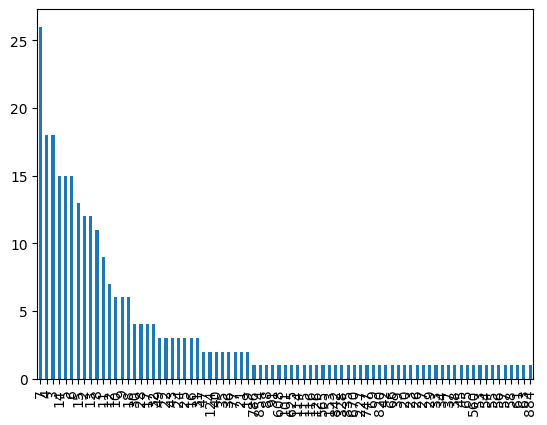

In [269]:
df19['Макс. ПДЗ за 2019 год, дней'].loc[df19['Макс. ПДЗ за 2019 год, дней']>1].value_counts().plot(kind='bar')

In [277]:
# рассчет квантилей
# 1 как и 0 считаем незначительной задержкой
quan =[.2, .4, .6, .8, 1]

print(df19['Макс. ПДЗ за 2019 год, дней'].loc[df19['Макс. ПДЗ за 2019 год, дней']>1].quantile(q=quan))

0.2      5.0
0.4      8.4
0.6     15.0
0.8     32.8
1.0    884.0
Name: Макс. ПДЗ за 2019 год, дней, dtype: float64


In [279]:
bins = [-1, 1, 5, 15, 31, 62, 10000]
labels = [1,2,3,4,5,6]
# min Risk  1 & 2 bins
# medium Risk  3 & 4 bins
# max Risk   5 & 6 bins

df19['Макс. ПДЗ за 2019 год, дней_binned'] = pd.cut(df19['Макс. ПДЗ за 2019 год, дней'], bins=bins, labels=labels)
df19['Макс. ПДЗ за 2019 год, дней_binned'].value_counts()

1    244
3    120
2     63
4     42
5     32
6     30
Name: Макс. ПДЗ за 2019 год, дней_binned, dtype: int64

<AxesSubplot:>

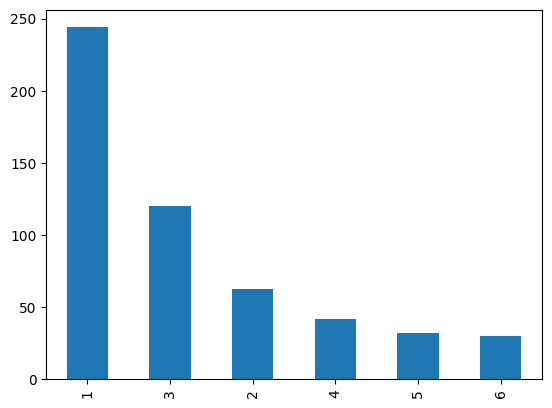

In [291]:
df19['Макс. ПДЗ за 2019 год, дней_binned'].value_counts().plot(kind='bar')#.astype('int').sort_values().plot(kind='bar')

# Общая сумма ПДЗ свыше 5-ти дней за 2019 год, руб.

In [293]:
# Квантили для задолженностей более 1 дня
quan =[.2, .4, .6, .8, 1]

print(df19['Общая сумма ПДЗ свыше 5-ти дней за 2019 год, руб.'].loc[df19['Общая сумма ПДЗ свыше 5-ти дней за 2019 год, руб.']>1].quantile(q=quan))

0.2    4.767219e+05
0.4    1.476376e+06
0.6    5.026986e+06
0.8    1.563352e+07
1.0    2.477138e+08
Name: Общая сумма ПДЗ свыше 5-ти дней за 2019 год, руб., dtype: float64


In [294]:
bins = [-1, 1, 500_000, 1_500_000, 5_000_000, 15_500_000, 5_000_000_000]
labels = [1,2,3,4,5,6]

# min Risk  1 & 2 bins
# medium Risk  3 bin
# max Risk   4 & 5 & 6 bins

df19['Общая сумма ПДЗ свыше 5-ти дней за 2019 год, руб._binned'] = pd.cut(df19['Общая сумма ПДЗ свыше 5-ти дней за 2019 год, руб.'], bins=bins, labels=labels)
df19['Общая сумма ПДЗ свыше 5-ти дней за 2019 год, руб._binned'].value_counts()

1    322
2     43
3     42
5     42
6     42
4     40
Name: Общая сумма ПДЗ свыше 5-ти дней за 2019 год, руб._binned, dtype: int64

# Кол-во просрочек свыше 5-ти дней за 2019 год, шт.

In [298]:
# Квантили для задолженностей более 1 дня
fname='Кол-во просрочек свыше 5-ти дней за 2019 год, шт.'

quan =[.2, .4, .6, .8, 1]

print(df19[fname].loc[df19[fname]>1].quantile(q=quan))

0.2      3.0
0.4      5.0
0.6     11.0
0.8     23.0
1.0    288.0
Name: Кол-во просрочек свыше 5-ти дней за 2019 год, шт., dtype: float64


In [299]:
bins = [-1, 1, 3, 5, 11, 23, 5000]
labels = [1,2,3,4,5,6]
fname='Кол-во просрочек свыше 5-ти дней за 2019 год, шт.'

# min Risk  1 & 2 bins
# medium Risk  3 & 4 bins
# max Risk   5 & 6 bins

df19[fname + '_binned'] = pd.cut(df19[fname], bins=bins, labels=labels)
df19[fname + '_binned'].value_counts()

1    350
2     54
5     35
6     34
4     31
3     27
Name: Кол-во просрочек свыше 5-ти дней за 2019 год, шт._binned, dtype: int64

# % Длительных Просрочек 

In [300]:
df19[['Кол-во просрочек свыше 5-ти дней за 2019 год, шт.', 'Кол-во раз ПДЗ за 2019 год, шт.']]

Кол-во просрочек свыше 5-ти дней за 2019 год, шт.  \
0                                                    0   
1                                                    0   
2                                                    1   
3                                                    0   
4                                                    0   
..                                                 ...   
526                                                  0   
527                                                  0   
528                                                  0   
529                                                  0   
530                                                  0   

     Кол-во раз ПДЗ за 2019 год, шт.  
0                                  0  
1                                  0  
2                                  2  
3                                  0  
4                                  2  
..                               ...  
526                                0  
527                                0  
528                                0  
529                                0  
530                                0  

[531 rows x 2 columns]

In [305]:
n1='Кол-во просрочек свыше 5-ти дней за 2019 год, шт.'
n2='Кол-во раз ПДЗ за 2019 год, шт.'

df19['Perc_dlit_prosroch']= df19[n1]/df19[n2]

df19['Perc_dlit_prosroch'] = df19['Perc_dlit_prosroch'].fillna(0)
df19['Perc_dlit_prosroch']=df19['Perc_dlit_prosroch']*100
df19['Perc_dlit_prosroch']=df19['Perc_dlit_prosroch'].astype('int')
df19['Perc_dlit_prosroch'].value_counts()

0      307
100     36
50      16
66      11
25       8
      ... 
62       1
60       1
52       1
58       1
2        1
Name: Perc_dlit_prosroch, Length: 73, dtype: int64

In [306]:
bins = [-1, 16, 32, 50, 66, 78, 100]
labels = [1,2,3,4,5,6]
fname='Perc_dlit_prosroch'

# min Risk  1 & 2 bins
# medium Risk  3 & 4 bins
# max Risk   5 & 6 bins

df19[fname + '_binned'] = pd.cut(df19[fname], bins=bins, labels=labels)
df19[fname + '_binned'].value_counts()

1    354
3     49
6     48
2     38
4     32
5     10
Name: Perc_dlit_prosroch_binned, dtype: int64

# NEW TARGET

## В дальнейшем предлагается корректировка весовых коэффициентов для каждого из компонента целевого признака в соответствии с уровнем важности

In [311]:
df19['NEW_TARGET']= \
df19['Макс. ПДЗ за 2019 год, дней_binned'].astype('int')* \
df19['Общая сумма ПДЗ свыше 5-ти дней за 2019 год, руб._binned'].astype('int')* \
df19['Кол-во просрочек свыше 5-ти дней за 2019 год, шт._binned'].astype('int')* \
df19['Perc_dlit_prosroch_binned'].astype('int')

<AxesSubplot:>

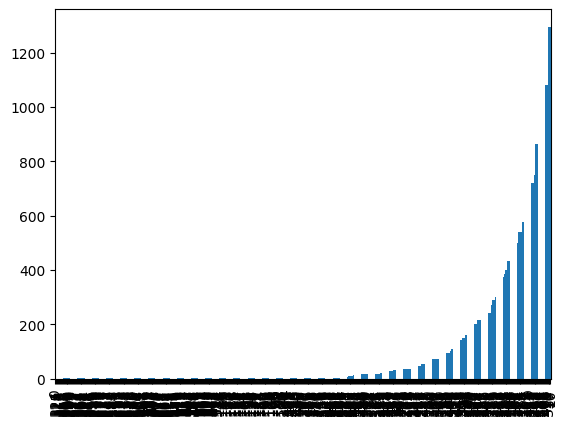

In [379]:
df19['NEW_TARGET'].sort_values().plot(kind='bar')

In [320]:
bins = [-1, 200, 400, 600, 800, 1000, 2000]
labels = [1,2,3,4,5,6]
fname='NEW_TARGET'

# min Risk  1 & 2 bins
# medium Risk  3 & 4 bins
# max Risk   5 & 6 bins

df19[fname + '_binned'] = pd.cut(df19[fname], bins=bins, labels=labels)
df19[fname + '_binned'].value_counts()

1    452
2     32
3     21
4      9
5      9
6      8
Name: NEW_TARGET_binned, dtype: int64

<AxesSubplot:ylabel='Frequency'>

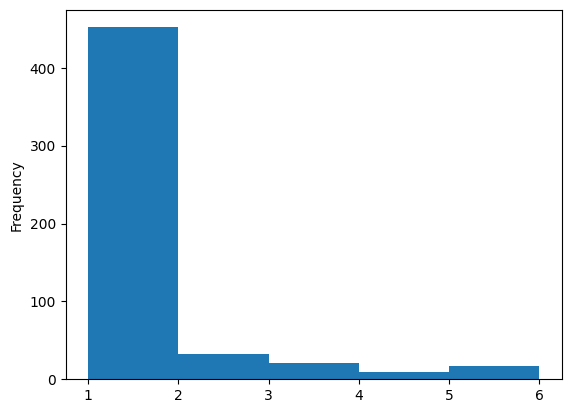

In [375]:
df19['NEW_TARGET_binned'].sort_values(ascending=False).plot(kind='hist', bins=5)

### Протестируем возможность предсказания нового таргета

In [365]:
from sklearn.model_selection import train_test_split

y = 'NEW_TARGET'
df19[y] = df19[y].astype('int')
X_train, X_test, y_train, y_test = train_test_split(df19[cols2pred], df19[y], test_size=0.25, random_state=42)

model3 = CatBoostRegressor(iterations=1500,
                          #early_stopping_rounds=300,
#                           border_count = 128,
                           max_ctr_complexity = 8,  #10
#                           grow_policy = 'Depthwise',
#                           depth=8,
                          loss_function= 'RMSE', #RMSLE(),
                          #cat_features= CAT_COLS,
                          random_state= 42,
                          l2_leaf_reg = .8,
                          learning_rate=0.01,
                          verbose=500,
                          use_best_model=True,
                          eval_metric='RMSE'
                          ) #RMSLE_val()) 
    
model3.fit(X_train, y_train,
          eval_set =(X_test, y_test ),
          plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 225.9514553	test: 211.9872610	best: 211.9872610 (0)	total: 11.5ms	remaining: 17.3s
500:	learn: 117.7279520	test: 207.9015155	best: 206.3935287 (253)	total: 1.49s	remaining: 2.96s
1000:	learn: 65.3339942	test: 210.1213676	best: 206.3935287 (253)	total: 2.94s	remaining: 1.46s
1499:	learn: 38.0832695	test: 210.1866727	best: 206.3935287 (253)	total: 4.36s	remaining: 0us

bestTest = 206.3935287
bestIteration = 253

Shrink model to first 254 iterations.


In [329]:
from sklearn.model_selection import train_test_split

y = 'NEW_TARGET_binned'
df19[y]=df19[y].astype('int')

X_train, X_test, y_train, y_test = train_test_split(df19[cols2pred], df19[y], test_size=0.2, random_state=422)

In [337]:
from catboost import CatBoostClassifier
model5 = CatBoostClassifier(
    iterations=500,
    random_seed=43,
    loss_function='MultiClass',
    learning_rate=0.01
)
model5.fit(
    X_train, y_train,
    #cat_features=cat_features,
    eval_set=(X_test, y_test),
    #verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.7698193	test: 1.7713041	best: 1.7713041 (0)	total: 25.3ms	remaining: 12.6s
1:	learn: 1.7472804	test: 1.7491335	best: 1.7491335 (1)	total: 63.2ms	remaining: 15.7s
2:	learn: 1.7232872	test: 1.7259000	best: 1.7259000 (2)	total: 91.3ms	remaining: 15.1s
3:	learn: 1.7041418	test: 1.7076095	best: 1.7076095 (3)	total: 116ms	remaining: 14.4s
4:	learn: 1.6803456	test: 1.6852696	best: 1.6852696 (4)	total: 131ms	remaining: 13s
5:	learn: 1.6640714	test: 1.6700205	best: 1.6700205 (5)	total: 159ms	remaining: 13.1s
6:	learn: 1.6415291	test: 1.6478748	best: 1.6478748 (6)	total: 174ms	remaining: 12.3s
7:	learn: 1.6204213	test: 1.6279938	best: 1.6279938 (7)	total: 188ms	remaining: 11.6s
8:	learn: 1.6008896	test: 1.6084917	best: 1.6084917 (8)	total: 202ms	remaining: 11s
9:	learn: 1.5815885	test: 1.5893523	best: 1.5893523 (9)	total: 216ms	remaining: 10.6s
10:	learn: 1.5620839	test: 1.5703289	best: 1.5703289 (10)	total: 232ms	remaining: 10.3s
11:	learn: 1.5462407	test: 1.5563125	best: 1.5563125 

95:	learn: 0.8633262	test: 0.9189437	best: 0.9189437 (95)	total: 2.13s	remaining: 8.99s
96:	learn: 0.8591537	test: 0.9150683	best: 0.9150683 (96)	total: 2.17s	remaining: 9.02s
97:	learn: 0.8555341	test: 0.9119059	best: 0.9119059 (97)	total: 2.21s	remaining: 9.06s
98:	learn: 0.8517603	test: 0.9086998	best: 0.9086998 (98)	total: 2.25s	remaining: 9.11s
99:	learn: 0.8479316	test: 0.9053329	best: 0.9053329 (99)	total: 2.27s	remaining: 9.1s
100:	learn: 0.8441093	test: 0.9020488	best: 0.9020488 (100)	total: 2.3s	remaining: 9.09s
101:	learn: 0.8406467	test: 0.8992202	best: 0.8992202 (101)	total: 2.32s	remaining: 9.07s
102:	learn: 0.8371453	test: 0.8961620	best: 0.8961620 (102)	total: 2.35s	remaining: 9.07s
103:	learn: 0.8335651	test: 0.8929756	best: 0.8929756 (103)	total: 2.37s	remaining: 9.04s
104:	learn: 0.8297306	test: 0.8895717	best: 0.8895717 (104)	total: 2.39s	remaining: 8.99s
105:	learn: 0.8262577	test: 0.8866199	best: 0.8866199 (105)	total: 2.41s	remaining: 8.95s
106:	learn: 0.8229679	

195:	learn: 0.6323931	test: 0.7301228	best: 0.7301228 (195)	total: 4.47s	remaining: 6.94s
196:	learn: 0.6310429	test: 0.7291256	best: 0.7291256 (196)	total: 4.49s	remaining: 6.91s
197:	learn: 0.6298505	test: 0.7284854	best: 0.7284854 (197)	total: 4.52s	remaining: 6.89s
198:	learn: 0.6284691	test: 0.7276343	best: 0.7276343 (198)	total: 4.54s	remaining: 6.86s
199:	learn: 0.6270837	test: 0.7267049	best: 0.7267049 (199)	total: 4.55s	remaining: 6.83s
200:	learn: 0.6257255	test: 0.7257729	best: 0.7257729 (200)	total: 4.57s	remaining: 6.8s
201:	learn: 0.6242983	test: 0.7246635	best: 0.7246635 (201)	total: 4.59s	remaining: 6.77s
202:	learn: 0.6232216	test: 0.7238115	best: 0.7238115 (202)	total: 4.62s	remaining: 6.76s
203:	learn: 0.6218962	test: 0.7228073	best: 0.7228073 (203)	total: 4.64s	remaining: 6.74s
204:	learn: 0.6206922	test: 0.7220841	best: 0.7220841 (204)	total: 4.68s	remaining: 6.73s
205:	learn: 0.6192324	test: 0.7213222	best: 0.7213222 (205)	total: 4.71s	remaining: 6.72s
206:	learn:

293:	learn: 0.5372461	test: 0.6794894	best: 0.6794894 (293)	total: 6.57s	remaining: 4.61s
294:	learn: 0.5365929	test: 0.6791978	best: 0.6791978 (294)	total: 6.59s	remaining: 4.58s
295:	learn: 0.5357920	test: 0.6790718	best: 0.6790718 (295)	total: 6.62s	remaining: 4.56s
296:	learn: 0.5351432	test: 0.6786394	best: 0.6786394 (296)	total: 6.64s	remaining: 4.54s
297:	learn: 0.5345628	test: 0.6784867	best: 0.6784867 (297)	total: 6.66s	remaining: 4.51s
298:	learn: 0.5338396	test: 0.6781998	best: 0.6781998 (298)	total: 6.7s	remaining: 4.5s
299:	learn: 0.5331962	test: 0.6779179	best: 0.6779179 (299)	total: 6.72s	remaining: 4.48s
300:	learn: 0.5325706	test: 0.6775961	best: 0.6775961 (300)	total: 6.74s	remaining: 4.46s
301:	learn: 0.5319525	test: 0.6772856	best: 0.6772856 (301)	total: 6.77s	remaining: 4.44s
302:	learn: 0.5313061	test: 0.6769835	best: 0.6769835 (302)	total: 6.79s	remaining: 4.42s
303:	learn: 0.5307676	test: 0.6768679	best: 0.6768679 (303)	total: 6.82s	remaining: 4.4s
304:	learn: 0

391:	learn: 0.4848527	test: 0.6637279	best: 0.6636864 (390)	total: 8.74s	remaining: 2.41s
392:	learn: 0.4842028	test: 0.6637316	best: 0.6636864 (390)	total: 8.77s	remaining: 2.39s
393:	learn: 0.4838755	test: 0.6636534	best: 0.6636534 (393)	total: 8.8s	remaining: 2.37s
394:	learn: 0.4833858	test: 0.6635846	best: 0.6635846 (394)	total: 8.82s	remaining: 2.35s
395:	learn: 0.4829938	test: 0.6634233	best: 0.6634233 (395)	total: 8.84s	remaining: 2.32s
396:	learn: 0.4826956	test: 0.6632921	best: 0.6632921 (396)	total: 8.86s	remaining: 2.3s
397:	learn: 0.4822918	test: 0.6633833	best: 0.6632921 (396)	total: 8.88s	remaining: 2.27s
398:	learn: 0.4818858	test: 0.6635196	best: 0.6632921 (396)	total: 8.89s	remaining: 2.25s
399:	learn: 0.4814035	test: 0.6634516	best: 0.6632921 (396)	total: 8.91s	remaining: 2.23s
400:	learn: 0.4809557	test: 0.6633683	best: 0.6632921 (396)	total: 8.92s	remaining: 2.2s
401:	learn: 0.4804500	test: 0.6633923	best: 0.6632921 (396)	total: 8.94s	remaining: 2.18s
402:	learn: 0

489:	learn: 0.4476549	test: 0.6626430	best: 0.6623520 (440)	total: 10.8s	remaining: 221ms
490:	learn: 0.4472467	test: 0.6627439	best: 0.6623520 (440)	total: 10.8s	remaining: 199ms
491:	learn: 0.4470082	test: 0.6627654	best: 0.6623520 (440)	total: 10.9s	remaining: 177ms
492:	learn: 0.4467638	test: 0.6627383	best: 0.6623520 (440)	total: 10.9s	remaining: 155ms
493:	learn: 0.4463712	test: 0.6627878	best: 0.6623520 (440)	total: 10.9s	remaining: 133ms
494:	learn: 0.4460520	test: 0.6628143	best: 0.6623520 (440)	total: 10.9s	remaining: 110ms
495:	learn: 0.4457005	test: 0.6627107	best: 0.6623520 (440)	total: 10.9s	remaining: 88.3ms
496:	learn: 0.4454305	test: 0.6628339	best: 0.6623520 (440)	total: 11s	remaining: 66.2ms
497:	learn: 0.4450809	test: 0.6628469	best: 0.6623520 (440)	total: 11s	remaining: 44.1ms
498:	learn: 0.4447936	test: 0.6629669	best: 0.6623520 (440)	total: 11s	remaining: 22ms
499:	learn: 0.4443176	test: 0.6629259	best: 0.6623520 (440)	total: 11s	remaining: 0us

bestTest = 0.6623

<AxesSubplot:>

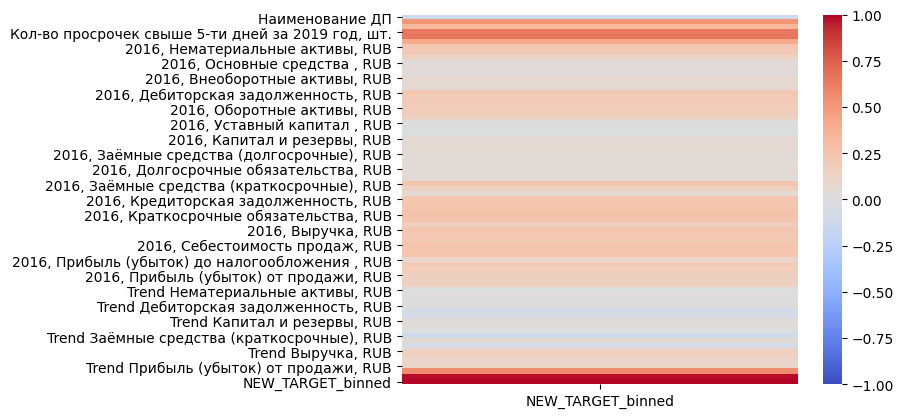

In [401]:
import seaborn as sns

upp_mat = np.triu(df19.corr())

sns.heatmap(df19.corr()[['NEW_TARGET_binned']], vmin = -1, vmax = +1, annot = False, cmap = 'coolwarm')


#sns.heatmap(df19.corr())